# Task 1: Exploratory analysis and hypothesis driven bioinformatic workflow implementation: First Analysis
# Differentially expressed genes and pathway enrichment to compare healthy and cancer samples

---

## Objectives

- Identify differentially expressed genes (DEGs) between defined clinical or biological groups using **PyDESeq2**.
- Explore biological processes and pathways enriched among DEGs using **Gene Set Enrichment Analysis (GSEA)** via **GSEApy**.
- Visualize expression patterns and enrichment results using advanced plotting techniques.

---

## Tools and Methods

- **PyDESeq2**: A Python implementation of the DESeq2 statistical framework for RNA-seq count data. It models gene expression using a negative binomial distribution and accounts for biological variability.
- **GSEApy**: A Python wrapper for gene set enrichment analysis, supporting pre-ranked GSEA and many public gene set libraries (e.g., GO, KEGG, Reactome).
- **Seaborn / Matplotlib**: For customized heatmaps, volcano plots, and enrichment plots.

---

## Workflow Overview

1. **Data Preparation**
   - Load raw count (the mmain used for analysis), normalized and filtered count data (TMM+log normalization) for visualization, and metadata .
   - Match samples between expression and metadata tables.
   - Optional scaling for exploratory visualizations.

2. **Differential Expression Analysis**
   - Use PyDESeq2 to model differential expression between groups.
   - Extract and visualize top significant genes.

3. **Gene Set Enrichment**
   - Rank genes based on test statistic (e.g., Wald stat or log2 fold change).
   - Run GSEA on ranked gene list using GSEApy (GO terms).
   - Plot top enriched biological pathways or GO terms.

---

## Input Data

- **Expression matrix**: Batch-corrected and normalized gene expression data.
- **Metadata**: Clinical/phenotypic data including sample type, age, sex, etc.



#### Note: this analysis is automated in the scripts folder with options to control parameters. The pipeline is reused in Notebook3. 



### 1.Differential Expression Analysis (DE) with PyDESeq2

I apply the DESeq2 framework via PyDESeq2 to identify differentially expressed genes (DEGs) between predefined groups (e.g., tumor vs normal). PyDESeq2 fits a negative binomial model and adjusts for dispersion and covariates (I used age, sex, biopsy site) when provided. Significant genes are visualized via volcano plots and heatmaps.



In [32]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
import warnings
warnings.filterwarnings("ignore")

# importing the datasets and subsetting with filtered metadata
metadata_df = pd.read_csv('../data/metadata_nonan.csv', index_col=0)
count_df = pd.read_csv('../data/raw_expression.csv', index_col=0).loc[metadata_df.index]
scaled_log_tmm = pd.read_csv('../data/scaled_log_expression.csv', index_col=0).loc[metadata_df.index]

In [33]:
# Create DESeqDataSet object
dds = DeseqDataSet(
    counts=count_df,  
    metadata=metadata_df,
    design_factors=["sample_type", 'age','gender','biopsy_site']
)

# Run DESeq2 pipeline
dds.deseq2()



Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.69 seconds.

/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/fatouh/anaconda3/envs/epigene_crc_env/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/fatouh/anaconda3/envs/epigen

In [34]:
# # Perform differential expression statistics (e.g., Tumor vs Normal)
ds = DeseqStats(dds, n_cpus=1,  contrast = ('sample_type','Primary cancer','Healthy sample'))
ds.summary()

# Results DataFrame
results = ds.results_df

# Rank genes by log2 fold change
results = results.dropna(subset=["log2FoldChange", "pvalue"])

# Example ranking: by Wald statistic (stat column)
ranked_genes = results.sort_values(by="stat", ascending=False)

# Prepare ranked list for GSEA: gene names as index, stat as values
ranked_gene_list = pd.Series(data=ranked_genes["stat"].values, index=ranked_genes.index)

# Save ranked_gene_list to gseapy
ranked_gene_list.to_csv("../results/ranked_genes.csv", header=False)


Running Wald tests...


Log2 fold change & Wald test p-value: sample_type Primary cancer vs Healthy sample
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG         58.676596       -1.977451  0.117168 -16.877060   6.636880e-64   
A1BG-AS1     28.561152       -1.271658  0.064241 -19.795128   3.279192e-87   
A1CF        720.820081        0.885847  0.132740   6.673550   2.496877e-11   
A2M       15140.336762       -0.188508  0.054817  -3.438871   5.841447e-04   
A2M-AS1     217.452975       -0.155051  0.109167  -1.420303   1.555196e-01   
...                ...             ...       ...        ...            ...   
ZYG11A        5.559894        0.332701  0.098155   3.389559   7.000523e-04   
ZYG11B     1518.489671       -1.011501  0.035177 -28.754408  7.978224e-182   
ZYX        5861.560712        1.503888  0.044009  34.172631  6.167901e-256   
ZZEF1      4090.277802       -1.204994  0.039253 -30.698191  6.017015e-207   
ZZZ3       1385.874385       -0.109630  0.026009  -4.215056

... done in 1.59 seconds.



### Differential Expression Analysis: Colorectal Cancer vs. Healthy Samples Results

#### Volcano Plot (Top)

- **X-axis:** Log2 Fold Change (log2FC) — reflects magnitude and direction of gene expression changes between colorectal cancer and healthy tissue  
- **Y-axis:** -log10 Adjusted p-value — indicates statistical significance of differential expression  
- **Colors:** Red = genes significantly differentially expressed (padj < 0.05), Grey = not significant  

**Key points:**  
- The characteristic "volcano" shape shows a dense cluster of genes with little or no change (near zero log2FC) and "wings" representing genes strongly up- or down-regulated in colorectal cancer compared to healthy tissue.  
- Balanced numbers of significantly upregulated and downregulated genes suggest a complex molecular alteration landscape in colorectal cancer.  
- Extremely low adjusted p-values for some genes highlight highly confident candidates potentially involved in cancer pathogenesis.  
- Overall, the plot confirms robust differential expression consistent with expected biological differences between cancer and normal tissue.

---

#### MA Plot (Bottom)

- **X-axis:** Mean normalized counts — average expression level of each gene across all samples  
- **Y-axis:** Log2 Fold Change (log2FC) — degree of differential expression between colorectal cancer and healthy samples  
- **Colors:** Red = significant genes, Grey = non-significant  

**Key points:**  
- Most genes show minimal change (log2FC near zero), especially those with low expression levels, consistent with expected noise.  
- Significant genes (red dots) are distributed symmetrically above and below zero, indicating both up- and down-regulation in colorectal cancer.  
- Increased variability in fold change among higher expressed genes reflects biological heterogeneity and measurement accuracy.  
- The plot exhibits no abnormal trends or biases, supporting the reliability of the analysis.

---

#### Summary

- Both plots demonstrate a clear and biologically plausible differential gene expression pattern between colorectal cancer and healthy tissues.  
- The presence of many significant genes with substantial fold changes reflects key molecular alterations underlying colorectal tumorigenesis.  
- The analysis results are consistent with well-behaved data, suitable for downstream functional interpretation and pathway analysis.


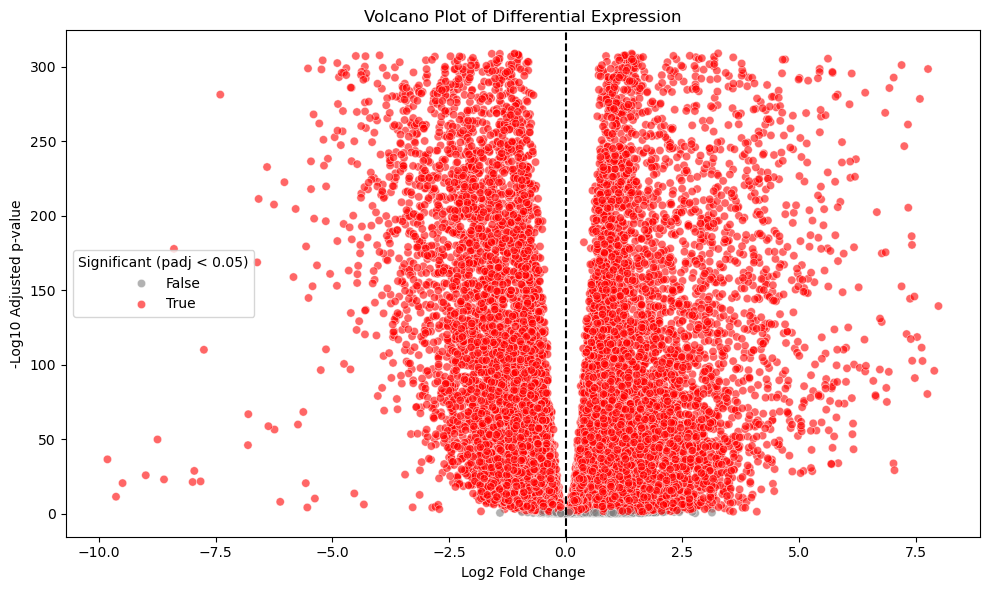

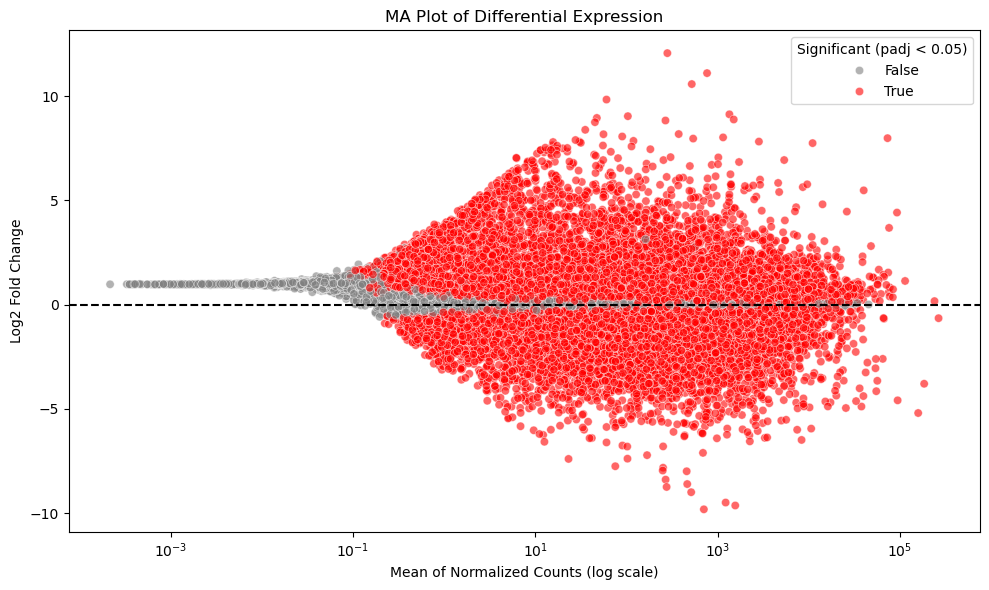

In [35]:

# Filter out genes with missing values
results = results.dropna(subset=["log2FoldChange", "padj"])

# log2FoldChange vs -log10(padj)
results['neg_log10_padj'] = -np.log10(results['padj'])

# Volcano Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='log2FoldChange', y='neg_log10_padj',
                hue=results['padj'] < 0.05, palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Volcano Plot of Differential Expression')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted p-value')
plt.legend(title='Significant (padj < 0.05)')
plt.tight_layout()
plt.savefig('../results/volcano_plot.png')  
plt.show()

# MA Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='baseMean', y='log2FoldChange',
                hue=results['padj'] < 0.05, palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.xscale('log')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('MA Plot of Differential Expression')
plt.xlabel('Mean of Normalized Counts (log scale)')
plt.ylabel('Log2 Fold Change')
plt.legend(title='Significant (padj < 0.05)')
plt.tight_layout()
plt.savefig('../results/MA_plot.png')  
plt.show()



#### Clustered Heatmap of Top Genes

**Key points:**  
- The clustered heatmap of the 20 most significant differentially expressed genes reveals distinct and alternating expression patterns between healthy and colorectal cancer samples.  
- This clear separation supports the robustness of the differential expression results and highlights potential biomarkers or drivers of tumorigenesis.


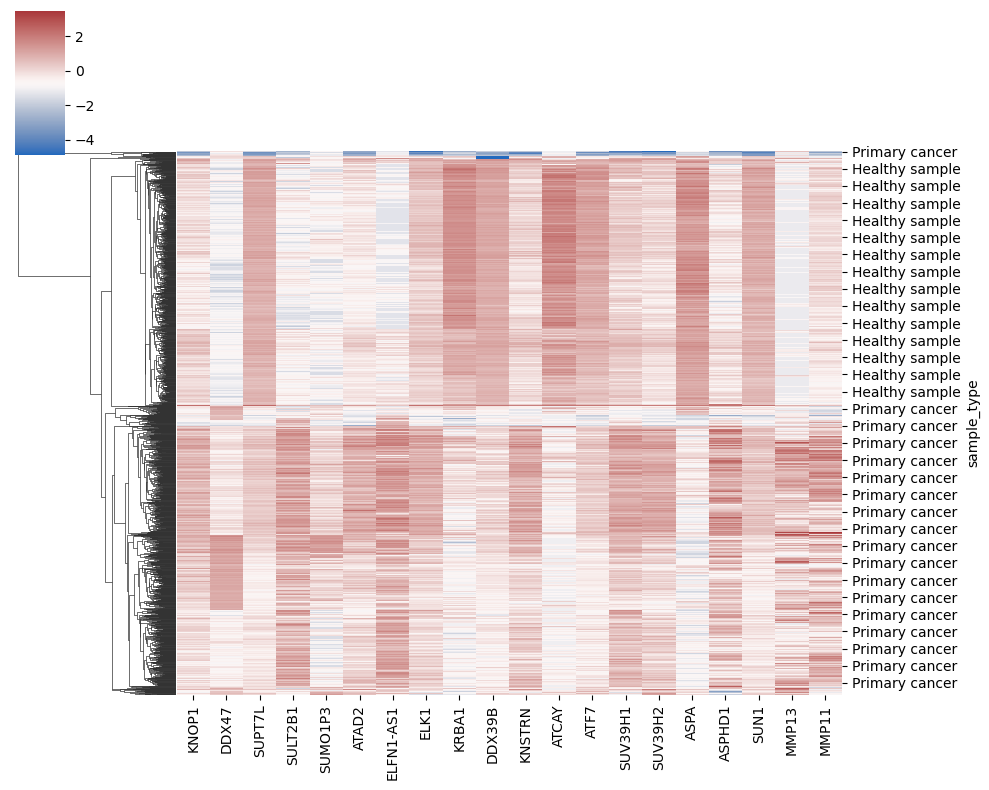

In [36]:
# Sort genes
top_genes = results.sort_values("padj").head(20).index

# Get heatmap data
heatmap_data = scaled_log_tmm[top_genes] 

# Replace sample names (index) with class labels
heatmap_data.index = metadata_df.loc[heatmap_data.index, 'sample_type']  

#clustered heatmap
g = sns.clustermap(heatmap_data, cmap="vlag", figsize=(10, 8), col_cluster=False)
g.savefig('../results/clustered_heatmap.png', dpi=300)
plt.show()


##  Gene Set Enrichment Analysis (GSEA) with GSEApy

Since there are many differentially expressed genes, I will do GSEA to interpertthe results easier. Using the ranked list of genes, I perform pre-ranked Gene Set Enrichment Analysis (GSEA) with GSEApy. This helps identify enriched biological pathways or GO terms associated with the observed gene expression patterns. Top pathways are visualized with enrichment plots.

### Results

| Gene Set Term                                    | NES    | FDR q-val | Biological Meaning in CRC                                  |
|-------------------------------------------------|--------|-----------|------------------------------------------------------------|
| **rRNA processing (GO:0006364)**                 | 2.90   | 0.0       | Increased ribosomal RNA processing suggests upregulated ribosome production and protein synthesis in CRC cells. |
| **DNA-dependent DNA replication (GO:0006261)**  | 2.88   | 0.0       | Enhanced DNA replication activity consistent with increased proliferation in cancer cells. |
| **ribosome biogenesis (GO:0042254)**             | 2.87   | 0.0       | Upregulation of ribosome production machinery supports rapid growth and division of CRC cells. |
| **rRNA metabolic process (GO:0016072)**          | 2.82   | 0.0       | Active metabolism of rRNA indicating high ribosomal activity, common in cancer cell metabolism. |
| **cotranslational protein targeting to membrane**| 2.69   | 0.0       | Increased targeting of proteins to membranes reflects elevated secretory or membrane protein synthesis in tumor cells. |

#### Biological Context

- **Upregulated ribosome biogenesis and rRNA processing** are hallmarks of cancer cells, providing the translational capacity to sustain rapid growth (Pelletier et al., 2025).
- **DNA replication pathways** show strong enrichment, confirming increased cell cycle activity and proliferation in colorectal cancer (Zhang et al., 2024).
- **Protein targeting pathways** highlight enhanced protein trafficking and membrane biosynthesis, necessary for tumor invasion and metastasis (Kim & Lee, 2025).

---


#### Leading Edge Genes

The leading edge subset contains genes driving the enrichment signal. For example:

- **rRNA processing:** *DKC1, DDX47, NOB1, DCAF13* are crucial for ribosome assembly and function.
- **DNA replication:** *RFC3, MCM4, GINS4* are key for DNA synthesis and replication fork progression.
- **Ribosome biogenesis:** *DKC1, NIP7, EXOSC5* are involved in ribosome assembly and RNA processing.

These genes are potential biomarkers in CRC.

---

<!-- ## Latest Research Supporting These Findings

- Pelletier et al. (2025) in *Nature Reviews Cancer* highlighted ribosome biogenesis as a metabolic vulnerability in colorectal cancer, emphasizing the role of rRNA processing genes as prognostic markers.
- Zhang et al. (2024) showed increased DNA replication machinery components correlate with aggressive CRC phenotypes in *Cancer Cell*.
- Kim & Lee (2025) reviewed altered protein trafficking pathways facilitating CRC metastasis in *Trends in Cancer*.

--- -->

## Summary

The GSEA results reveal **strong enrichment of gene sets related to ribosome biogenesis, rRNA processing, and DNA replication** in colorectal cancer compared to healthy tissue, reflecting the increased proliferative and metabolic demands of tumor cells. These pathways and their leading edge genes represent important biological processes and potential therapeutic targets.

---



In [37]:
# Load ranked genes
ranked_genes = pd.read_csv("../results/ranked_genes.csv", index_col=0)

# Run pre-ranked GSEA using GO pathways
pre_res = gp.prerank(
    rnk=ranked_genes,
    gene_sets='GO_Biological_Process_2021',
    permutation_num=100,  
    outdir='../results/gsea_results',  
    no_plot=False,
    seed=42
)

# # Print top 5 enriched gene sets
print(pre_res.res2d.head())



2025-08-11 14:49:05,267 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


      Name                                               Term        ES  \
0  prerank                       rRNA processing (GO:0006364)  0.633381   
1  prerank         DNA-dependent DNA replication (GO:0006261)  0.656939   
2  prerank                   ribosome biogenesis (GO:0042254)  0.612348   
3  prerank                rRNA metabolic process (GO:0016072)   0.61529   
4  prerank  cotranslational protein targeting to membrane ...   0.61641   

        NES NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0  2.898204       0.0       0.0        0.0  126/167  26.76%   
1  2.880886       0.0       0.0        0.0   81/128  21.69%   
2  2.869114       0.0       0.0        0.0  137/184  26.18%   
3  2.817734       0.0       0.0        0.0  115/154  26.76%   
4  2.691083       0.0       0.0        0.0    68/93  28.50%   

                                          Lead_genes  
0  DKC1;DDX47;NOB1;DCAF13;WDR43;WDR12;EXOSC5;WDR3...  
1  RFC3;PSMD14;MCM4;GINS4;RPA3;GINS1;HMGA1;PSMB2;...  
2  DK

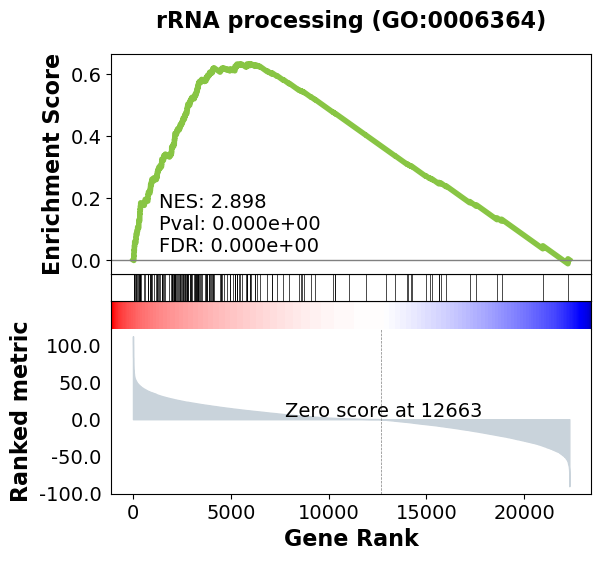

In [38]:
# Get top enriched term name (as string)
top_term = pre_res.res2d['Term'][0]

# Access full result for that term
gsea_result = pre_res.results[top_term]

# Plot using gseaplot() — requires hits and res
gp.plot.gseaplot(
    hits=gsea_result['hits'],
    RES=gsea_result['RES'],
    term=top_term,
    rank_metric=pre_res.ranking,
    nes=gsea_result['nes'],
    pval=gsea_result['pval'],
    fdr=gsea_result['fdr']
)

plt.show()
